## Null statistical model that preserves the internal correlations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.stats import spearmanr, pearsonr
import stat_utils as st

In [2]:
f = open('out_data/abr_measures.pickle', 'rb')
abr_measures = pickle.load(f)
f.close()
f = open('out_data/abr_labels.pickle', 'rb')
abr_labels = pickle.load(f)
f.close()
f = open('out_data/hiv_measures.pickle', 'rb')
hiv_measures = pickle.load(f)
f.close()
f = open('out_data/hiv_labels.pickle', 'rb')
hiv_labels = pickle.load(f)
f.close()

In [3]:
# Dictionary of number of samples per patient
ns = dict()
for pat, ms in abr_measures.items():
    ns[pat] = len(ms[0])
nm_abr = len(abr_labels)-2
nm_hiv = len(hiv_labels)-2

# Standard deviation for the rescaled corr coef
stds = st.compute_corrcoef_std(19, R=10000)

In [4]:
def compute_null_corr_matrices(hiv_measures, abr_measures, nm_hiv, nm_abr):
    """
    Computing the correlations between measures of HIV and, separately,
    measures of abr and building the covariavnce matrix
    """
    hiv_corr_mat, abr_corr_mat = dict(), dict()
    for pat in hiv_measures:
        hiv_corr_mat_pat, abr_corr_mat_pat = np.ones((nm_hiv, nm_hiv)), np.ones((nm_abr, nm_abr))
        hiv_ms, abr_ms = hiv_measures[pat], abr_measures[pat]
        for i in range(len(hiv_ms)-2):
            for j in range(i):
                r,p = pearsonr(hiv_ms[i], hiv_ms[j])
                hiv_corr_mat_pat[i,j] = r
                hiv_corr_mat_pat[j,i] = r
        hiv_corr_mat[pat] = hiv_corr_mat_pat
        for i in range(len(abr_ms)-2):
            for j in range(i):
                r,p = pearsonr(abr_ms[i], abr_ms[j])
                abr_corr_mat_pat[i,j] = r
                abr_corr_mat_pat[j,i] = r
        abr_corr_mat[pat] = abr_corr_mat_pat
    return hiv_corr_mat, abr_corr_mat

In [5]:
def generate_null_corr_measures(hiv_corr_mat, abr_corr_mat):
    """
    Generating one set of null measures as uncorrelated gaussian variables
    """
    ms_hiv, ms_abr = dict(), dict()
    for pi in range(len(abr_corr_mat)):
        pat = str(pi+1)
        ms_hiv[pat] = np.random.multivariate_normal(np.zeros(len(hiv_corr_mat[pat])), hiv_corr_mat[pat], size=ns[pat]).T
        ms_abr[pat] = np.random.multivariate_normal(np.zeros(len(abr_corr_mat[pat])), abr_corr_mat[pat], size=ns[pat]).T
    return ms_hiv, ms_abr

def generate_null_measures(npat, nm_hiv, nm_abr):
    """
    Generating one set of null measures as multivariate gaussian variables
    with specified covariance matrices
    """
    ms_hiv, ms_abr = dict(), dict()
    for pi in range(npat):
        pat = str(pi+1)
        ms_hiv[pat] = np.random.multivariate_normal(np.zeros(nm_hiv), np.identity(nm_hiv), size=ns[pat]).T
        ms_abr[pat] = np.random.multivariate_normal(np.zeros(nm_abr), np.identity(nm_abr), size=ns[pat]).T
    return ms_hiv, ms_abr

def generate_null_corrlogn_measures(hiv_corr_mat, abr_corr_mat):
    """
    Generating one set of null measures as multivariate log-normal variables
    with specified covariance matrices
    """
    ms_hiv, ms_abr = dict(), dict()
    for pi in range(len(abr_corr_mat)):
        pat = str(pi+1)
        ms_hiv[pat] = st.multivariate_lognormal(np.ones(len(hiv_corr_mat[pat])), hiv_corr_mat[pat], ns[pat], False).T
        ms_abr[pat] = st.multivariate_lognormal(np.ones(len(abr_corr_mat[pat])), abr_corr_mat[pat], ns[pat], False).T
    return ms_hiv, ms_abr

## Examples of a randomly generated scenario

/home/andrea/Documents/Immunology/HIV_coevo/turnover_analysis/stat_utils.py:155: RuntimeWarning: covariance is not positive-semidefinite.
  norm_samples = np.random.multivariate_normal(norm_mu, norm_cov, size=size)
/home/andrea/Documents/Immunology/HIV_coevo/turnover_analysis/stat_utils.py:66: RuntimeWarning: divide by zero encountered in log10
  kspval_frame = pd.DataFrame(np.log10(kspval[1:,:-1]), index=m1_labels[1:], columns=m2_labels[:-1])


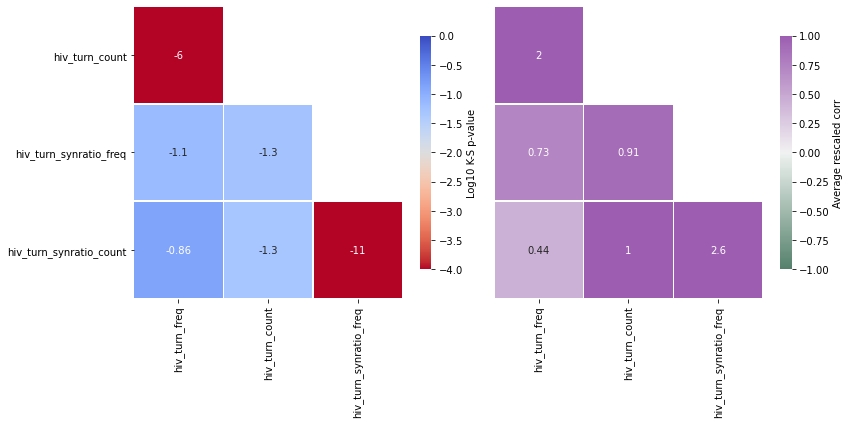

In [6]:
hiv_corr_mat, abr_corr_mat = compute_null_corr_matrices(hiv_measures, abr_measures, nm_hiv, nm_abr)
ms_hiv, ms_abr = generate_null_corrlogn_measures(hiv_corr_mat, abr_corr_mat)

hiv_rhos_null, ps = st.compute_rescaled_corr(ms_hiv, ms_hiv, True, stds)
kss_null, kspval_null, av_rho_null = st.compute_KS_stat(hiv_rhos_null, True)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1,ax2 = st.plot_correlation_heatmap(ax1,ax2, kspval_null, av_rho_null, hiv_labels[:-2],  hiv_labels[:-2], True)

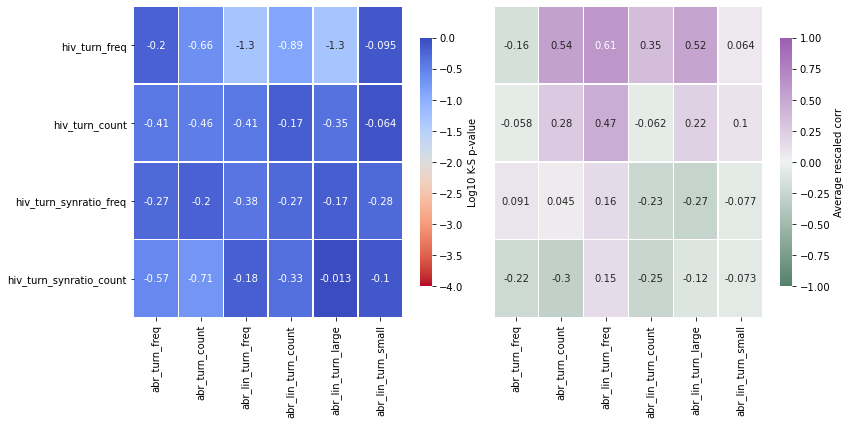

In [7]:
rhos, ps = st.compute_rescaled_corr(ms_hiv, ms_abr, False, stds)
kss, kspval, av_rho = st.compute_KS_stat(rhos, False)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1,ax2 = st.plot_correlation_heatmap(ax1,ax2, kspval, av_rho, hiv_labels[:-2], abr_labels[:-2], False)

In [8]:
def generate_null_ks(nm_hiv, nm_abr, R, temp_shift=0):
    """
    Generating an ensemble of null scenarios with gaussian variables
    without correlations
    """
    null_kss = np.zeros((R, nm_hiv, nm_abr))
    null_kspval = np.zeros((R, nm_hiv, nm_abr))
    for i in range(R):
        ms_hiv, ms_abr = generate_null_measures(len(hiv_measures), nm_hiv, nm_abr)
        rhos, ps = st.compute_rescaled_corr(ms_hiv, ms_abr, False, stds, temp_shift)
        kss, kspval, av_rho = st.compute_KS_stat(rhos, False)
        null_kss[i,:,:] = kss
        null_kspval[i,:,:] = kspval
    return null_kss, null_kspval

def generate_nullcorr_ks(hiv_measures, abr_measures, nm_hiv, nm_abr, R, temp_shift=0):
    """
    Generating an ensemble of null scenarios with gaussian variables
    preserving the empirical correlations of each set
    """
    hiv_corr_mat, abr_corr_mat = compute_null_corr_matrices(hiv_measures, abr_measures, nm_hiv, nm_abr)
    null_kss = np.zeros((R, nm_hiv, nm_abr))
    null_kspval = np.zeros((R, nm_hiv, nm_abr))
    for i in range(R):
        ms_hiv, ms_abr = generate_null_corr_measures(hiv_corr_mat, abr_corr_mat)
        rhos, ps = st.compute_rescaled_corr(ms_hiv, ms_abr, False, stds, temp_shift)
        kss, kspval, av_rho = st.compute_KS_stat(rhos, False)
        null_kss[i,:,:] = kss
        null_kspval[i,:,:] = kspval
    return null_kss, null_kspval

def generate_nullcorrln_ks(hiv_measures, abr_measures, nm_hiv, nm_abr, R, temp_shift=0):
    """
    Generating an ensemble of null scenarios with log-normal variables
    preserving the empirical correlations of each set
    """
    hiv_corr_mat, abr_corr_mat = compute_null_corr_matrices(hiv_measures, abr_measures, nm_hiv, nm_abr)
    null_kss = np.zeros((R, nm_hiv, nm_abr))
    null_kspval = np.zeros((R, nm_hiv, nm_abr))
    for i in range(R):
        ms_hiv, ms_abr = generate_null_corrlogn_measures(hiv_corr_mat, abr_corr_mat)
        rhos, ps = st.compute_rescaled_corr(ms_hiv, ms_abr, False, stds, temp_shift)
        kss, kspval, av_rho = st.compute_KS_stat(rhos, False)
        null_kss[i,:,:] = kss
        null_kspval[i,:,:] = kspval
    return null_kss, null_kspval

def compute_n_below_th(null_kspval, pval):
    """
    Given an ensemble of null scenarios of KS pvalues, it computes the counts
    of scenarios that have a number of events below the pval threshold.
    """
    n_below_th_counts = np.zeros(nm_hiv*nm_abr)
    for scenario in null_kspval:
        n_below_th = sum(sum(scenario < pval))
        n_below_th_counts[n_below_th] += 1
    
    return n_below_th_counts

def compute_prob_more_data(significances, null_kspval, true_kspval):
    """
    Given a list of KS pvalue significances, an ensemble of null scenarios of 
    KS pvalues, and the table of true pvalues of the data, it computes the
    probability of having more significant null scenarios than the ones
    observed in data at each significance threshold.
    """
    n_pvals = []
    for sign_th in significances:
        n_below_th_counts = compute_n_below_th(null_kspval, sign_th)
        n_below_th_true = sum(sum(true_kspval < sign_th))
        n_pvals.append(sum(n_below_th_counts[n_below_th_true:])/len(null_kspval))
    return np.array(n_pvals)

def compute_prob_more_ns(significances, null_kspval, ns):
    """
    Given a list of KS pvalue significances, an ensemble of null scenarios of 
    KS pvalues, and a list of numbers, ns, it computes the probability of having
    more significant null scenarions than ns at each significance threshold.
    """
    n_pvals = np.zeros((len(ns),len(significances)))
    for si, sign_th in enumerate(significances):
        n_below_th_counts = compute_n_below_th(null_kspval, sign_th)
        for ni, n in enumerate(ns):
            n_pvals[ni,si] = sum(n_below_th_counts[n:])/len(null_kspval)
    return np.array(n_pvals)

## Syncronous trajectories

In [9]:
true_rhos, true_ps = st.compute_rescaled_corr(hiv_measures, abr_measures, False, stds)
true_kss, true_kspval, true_av_rho = st.compute_KS_stat(true_rhos, False)

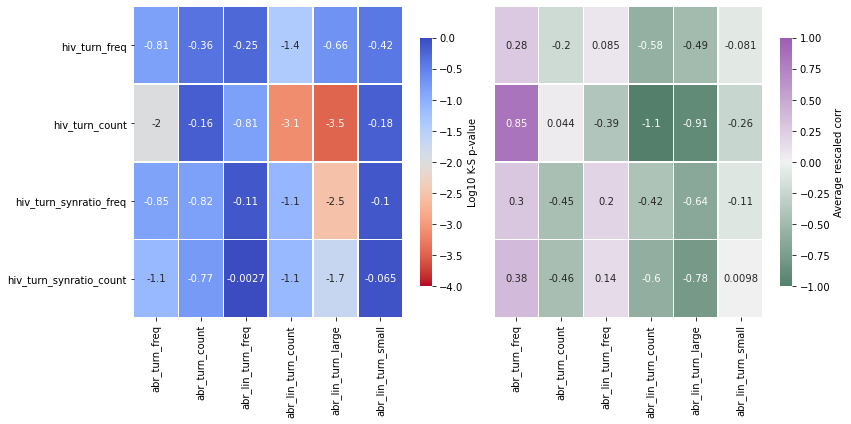

In [10]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1,ax2 = st.plot_correlation_heatmap(ax1,ax2, true_kspval[:-2,:-2], true_av_rho[:-2,:-2], hiv_labels[:-2], abr_labels[:-2], False)

### BH test

In [11]:
sorted_ksps = np.sort(true_kspval[:-2,:-2].flatten())
m = len(sorted_ksps)
count = 0
alpha = 0.05
while sorted_ksps[count] < alpha*(count+1)/m:
    print (np.log10(sorted_ksps[count]),sorted_ksps[count], alpha*(count+1)/m)
    count += 1
print (np.log10(sorted_ksps[count]),sorted_ksps[count], alpha*(count+1)/m)
    
print('The', count, 'smallest events are significant at ', alpha)

-3.4628485861620137 0.0003444700069716986 0.0020833333333333333
-3.1099156278708273 0.0007763979359160409 0.004166666666666667
-2.5359997161075056 0.002910719020764079 0.006250000000000001
-1.9805770944279777 0.010457380382492977 0.008333333333333333
The 3 smallest events are significant at  0.05


In [12]:
# Generating the null scenarios (it takes few hours)

# Uncorrelated scenario
#null_kss, null_kspval = generate_null_ks(nm_hiv, nm_abr, 50000)
#print('1')

# Correlated scenario with multivariate gaussians
#nullmv_kss, nullmv_kspval = generate_nullcorr_ks(hiv_measures, abr_measures, nm_hiv, nm_abr, 50000)
#print('2')

# Correlated scenario with multivariate  lognormals
nullmvln_kss, nullmvln_kspval = generate_nullcorrln_ks(hiv_measures, abr_measures, nm_hiv, nm_abr, 40000)
#print('3')

In [13]:
#plt.hist(null_kss.flatten(), bins=20, density=True, alpha=0.5)
#plt.hist(nullmv_kss.flatten(), bins=20, density=True, alpha=0.5)
#plt.hist(nullmvln_kss.flatten(), bins=20, density=True, alpha=0.5)
#h = plt.hist(true_kss[:-2,:-2].flatten(), bins=20, density=True, alpha=0.5)

In [14]:
sign_th = 0.001
#n_below_th_counts = compute_n_below_th(null_kspval, sign_th)
#n_below_th_counts_mv = compute_n_below_th(nullmv_kspval, sign_th)
n_below_th_counts_mvln = compute_n_below_th(nullmvln_kspval, sign_th)

In [15]:
n_below_th_true = sum(sum(true_kspval[:-2,:-2] < sign_th))
print('N pairs below', sign_th, 'KS pvalue in data:', n_below_th_true)

N pairs below 0.001 KS pvalue in data: 2


In [ ]:
print('Null model without correlations')
for i, c in enumerate(n_below_th_counts):
    if c > 0:
        print('Scenarios with', i, 'pairs below threshold:', int(c))
print('Fractions of scenarios with more counts than data:', sum(n_below_th_counts[n_below_th_true:])/sum(n_below_th_counts))

In [ ]:
print('Null model with correlations')
for i, c in enumerate(n_below_th_counts_mv):
    if c > 0:
        print('Scenarios with', i, 'pairs below threshold:', int(c))
print('Fractions of scenarios with more counts than data:', sum(n_below_th_counts_mv[n_below_th_true:])/sum(n_below_th_counts_mv))

In [16]:
print('Null model with correlations')
for i, c in enumerate(n_below_th_counts_mvln):
    if c > 0:
        print('Scenarios with', i, 'pairs below threshold:', int(c))
print('Fractions of scenarios with more counts than data:', sum(n_below_th_counts_mvln[n_below_th_true:])/sum(n_below_th_counts_mvln))

Null model with correlations
Scenarios with 0 pairs below threshold: 38856
Scenarios with 1 pairs below threshold: 1025
Scenarios with 2 pairs below threshold: 106
Scenarios with 3 pairs below threshold: 11
Scenarios with 4 pairs below threshold: 2
Fractions of scenarios with more counts than data: 0.002975


In [21]:
significances = np.logspace(np.log10(0.05),np.log10(np.min(true_kspval[:-2,:-2])),100)
ns = np.arange(1,7)
pval_more_ns = compute_prob_more_ns(significances, nullmvln_kspval, ns)
n_below_true = np.array([sum(sum(true_kspval[:-2,:-2] < th)) for th in significances])
prob_more_data = compute_prob_more_data(significances, nullmvln_kspval, true_kspval[:-2,:-2])

In [22]:
from matplotlib import cm
cmap = cm.get_cmap('plasma')

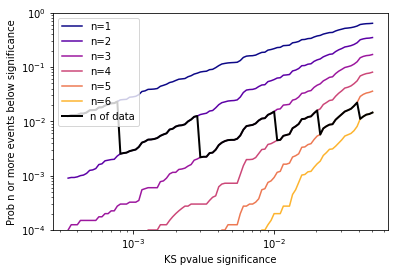

In [23]:
plt.xscale('log')
plt.yscale('log')
plt.xlabel('KS pvalue significance')
plt.ylabel('Prob n or more events below significance')
plt.ylim(0.0001,1)
for i in range(len(ns)):
    plt.plot(significances, pval_more_ns[i,:], c=cmap(i/(len(ns))), label='n='+str(ns[i]))
plt.plot(significances, prob_more_data, label='n of data', c='black', lw=2)
plt.legend()
plt.savefig('plots/null_signif.svg')

In [30]:
#pval_more_ns_mv = compute_prob_more_ns(significances, nullmv_kspval, ns)
prob_more_data_mv = compute_prob_more_data(significances, nullmvln_kspval, true_kspval[:-2,:-2])
pval_more_ns_mvln = compute_prob_more_ns(significances, nullmvln_kspval, ns)

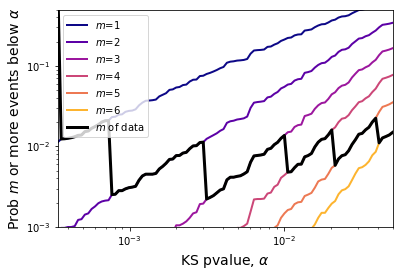

In [40]:
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'KS pvalue, $\alpha$', fontsize=14)
plt.ylabel(r'Prob $m$ or more events below $\alpha$', fontsize=14)
plt.xlim(min(significances),0.05)
plt.ylim(0.001,0.5)
for i in range(len(ns)):
    #plt.plot(significances, pval_more_ns_mv[i,:], c=cmap(i/(len(ns))), label='n='+str(ns[i]))
    plt.plot(significances, pval_more_ns_mvln[i,:], c=cmap(i/(len(ns))), label=r'$m$='+str(ns[i]), lw=2)
plt.plot(significances, prob_more_data_mv, label=r'$m$ of data', c='black', lw=3)
plt.legend()
plt.savefig('plots/nullcorr_signif.svg')

## HIV shift +1

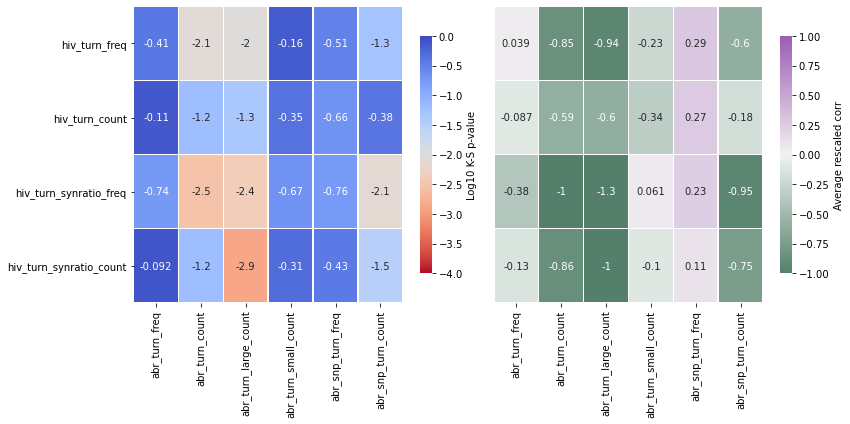

In [26]:
true_rhos1, true_ps1 = st.compute_rescaled_corr(hiv_measures, abr_measures, False, stds, 1)
true_kss1, true_kspval1, true_av_rho1 = st.compute_KS_stat(true_rhos1, False)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1,ax2 = st.plot_correlation_heatmap(ax1,ax2, true_kspval1[:-2,:-2], true_av_rho1[:-2,:-2], hiv_labels[:-2], abr_labels[:-2], False)

In [40]:
sorted_ksps1 = np.sort(true_kspval1[:-2,:-2].flatten())
m = len(sorted_ksps)
count = 0
alpha = 0.05
while sorted_ksps1[count] < alpha*(count+1)/m:
    print (np.log10(sorted_ksps1[count]), sorted_ksps1[count], alpha*(count+1)/m)
    count += 1
print (np.log10(sorted_ksps1[count]), sorted_ksps1[count], alpha*(count+1)/m)
    
print('The', count, 'smallest events are significant at ', alpha)

-2.871431709423049 0.0013445231694134358 0.0020833333333333333
-2.524395193577539 0.002989543013492104 0.004166666666666667
-2.3642380708539013 0.004322768012686846 0.006250000000000001
-2.1226162744515187 0.007540214932751248 0.008333333333333333
-2.0745326609005548 0.008423010442252445 0.010416666666666666
-2.025086963155074 0.009438718564004607 0.012500000000000002
-1.492527050965649 0.03217162138593155 0.014583333333333335
The 6 smallest events are significant at  0.05


In [84]:
significances1 = np.logspace(np.log10(0.05),np.log10(np.min(true_kspval1[:-2,:-2])),100)
ns = np.arange(1,9)
pval_more_ns1 = compute_prob_more_ns(significances1, null_kspval, ns)
n_below_true1 = np.array([sum(sum(true_kspval1[:-2,:-2] < th)) for th in significances1])
prob_more_data1 = compute_prob_more_data(significances1, null_kspval, true_kspval1[:-2,:-2])

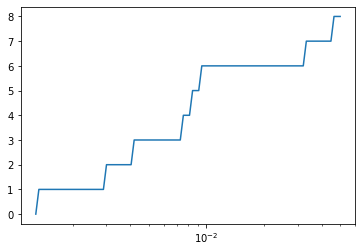

In [85]:
plt.xscale('log')
plt.plot(significances1, n_below_true1)

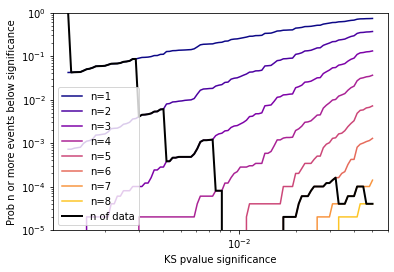

In [96]:
plt.xscale('log')
plt.yscale('log')
plt.xlabel('KS pvalue significance')
plt.ylabel('Prob n or more events below significance')
plt.ylim(0.00001,1)
for i in range(len(ns)):
    plt.plot(significances1, pval_more_ns1[i,:], c=cmap(i/(len(ns))), label='n='+str(ns[i]))
plt.plot(significances1, prob_more_data1, label='n of data', c='black', lw=2)
plt.legend()
plt.savefig('plots/null_signif_hivfront.svg')

In [88]:
pval_more_ns_mv1 = compute_prob_more_ns(significances1, nullmv_kspval, ns)
prob_more_data_mv1 = compute_prob_more_data(significances1, nullmv_kspval, true_kspval1[:-2,:-2])

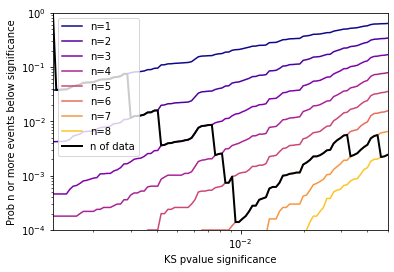

In [93]:
plt.xscale('log')
plt.yscale('log')
plt.xlabel('KS pvalue significance')
plt.ylabel('Prob n or more events below significance')
plt.xlim(min(significances1),0.05)
plt.ylim(0.0001,1)
for i in range(len(ns)):
    plt.plot(significances1, pval_more_ns_mv1[i,:], c=cmap(i/(len(ns))), label='n='+str(ns[i]))
plt.plot(significances1, prob_more_data_mv1, label='n of data', c='black', lw=2)
plt.legend()
plt.savefig('plots/nullcorr_signif_hivfront.svg')

## HIV shift -1

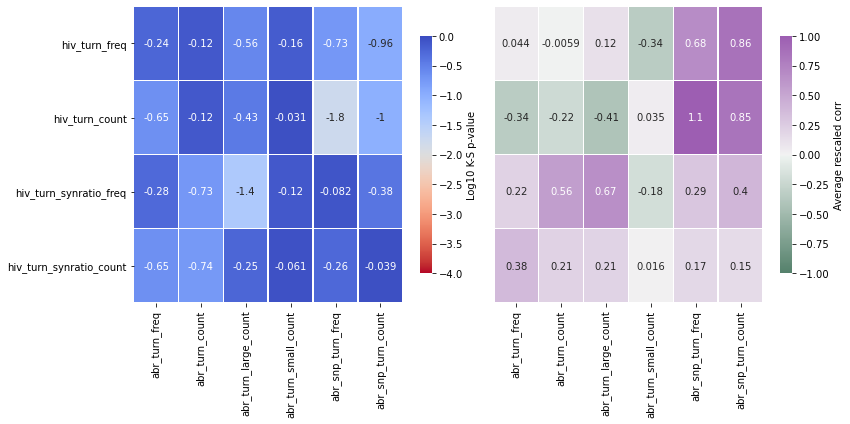

In [90]:
true_rhos2, true_ps2 = st.compute_rescaled_corr(hiv_measures, abr_measures, False, stds, -1)
true_kss2, true_kspval2, true_av_rho2 = st.compute_KS_stat(true_rhos2, False)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1,ax2 = st.plot_correlation_heatmap(ax1,ax2, true_kspval2[:-2,:-2], true_av_rho2[:-2,:-2], hiv_labels[:-2], abr_labels[:-2], False)

In [99]:
significances2= np.logspace(np.log10(0.05),np.log10(0.001),100)
ns = np.arange(1,6)
pval_more_ns2 = compute_prob_more_ns(significances2, null_kspval, ns)
n_below_true2 = np.array([sum(sum(true_kspval2[:-2,:-2] < th)) for th in significances1])
prob_more_data2 = compute_prob_more_data(significances1, null_kspval, true_kspval2[:-2,:-2])

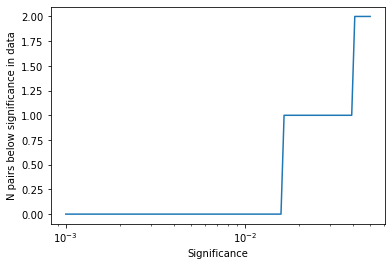

In [100]:
plt.xscale('log')
plt.xlabel('Significance')
plt.ylabel('N pairs below significance in data')
plt.plot(significances2, n_below_true2)

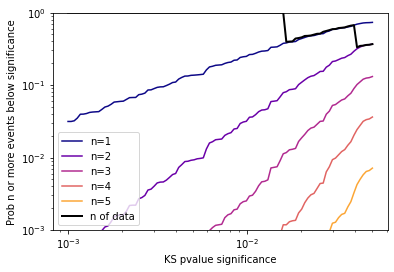

In [102]:
plt.xscale('log')
plt.yscale('log')
plt.xlabel('KS pvalue significance')
plt.ylabel('Prob n or more events below significance')
plt.ylim(0.001,1)
for i in range(len(ns)):
    plt.plot(significances2, pval_more_ns2[i,:], c=cmap(i/(len(ns))), label='n='+str(ns[i]))
plt.plot(significances2, prob_more_data2, label='n of data', c='black', lw=2)
plt.legend()
plt.savefig('plots/null_signif_hivback.svg')

In [104]:
pval_more_ns_mv2 = compute_prob_more_ns(significances2, nullmv_kspval, ns)
prob_more_data_mv2 = compute_prob_more_data(significances2, nullmv_kspval, true_kspval2[:-2,:-2])

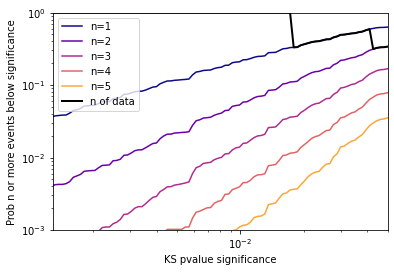

In [106]:
plt.xscale('log')
plt.yscale('log')
plt.xlabel('KS pvalue significance')
plt.ylabel('Prob n or more events below significance')
plt.xlim(min(significances1),0.05)
plt.ylim(0.001,1)
for i in range(len(ns)):
    plt.plot(significances2, pval_more_ns_mv2[i,:], c=cmap(i/(len(ns))), label='n='+str(ns[i]))
plt.plot(significances2, prob_more_data_mv2, label='n of data', c='black', lw=2)
plt.legend()
plt.savefig('plots/nullcorr_signif_hivback.svg')

## Plots for the figures

In [ ]:
fig = plt.figure(figsize=(3.5,2.25))
r,p = spearmanr(m[:,0],m[:,1])
#plt.xlabel('Measure 1')
#plt.ylabel('Measure 2')
plt.scatter(m[:,0],m[:,1], s=100)
plt.tight_layout()
plt.savefig('plots/corr_sketch_%i_%3.2f.svg' %(n,r))

In [ ]:
fig = plt.figure(figsize=(3.5,2.25))
plt.plot(m[:,0], lw=2)
plt.plot(m[:,1], lw=2)
plt.savefig('plots/traj_sketch_%i_%3.2f.svg' %(n,r))

In [ ]:
from scipy.stats import norm

In [ ]:
fig = plt.figure(figsize=(3.5,5))
rho_exe = np.array([0.76/stds[8], 0.34/stds[11],0.57/stds[15]])
plt.hist(rho_exe, bins=np.linspace(1,3,7), rwidth=0.9)
plt.plot(x, norm.pdf(x)*2)
plt.savefig('plots/rhos_and_norm.svg')

In [ ]:
rho_exe

In [ ]:
rho_dist = dict()

In [ ]:
R = 10000
rhos = []
rho = 0
n = 15
for _ in range(R):
    m = np.random.multivariate_normal([0,0], [[1,rho],[rho,1]], size=n)
    r,p = spearmanr(m[:,0],m[:,1])
    rhos.append(r)
print(np.mean(rhos))
rho_dist[n] = rhos

In [ ]:
fig = plt.figure(figsize=(4,3))
plt.hist(rho_dist[8], bins=16, density=True, histtype='step', lw=3)
plt.hist(rho_dist[11], bins=16, density=True, histtype='step', lw=3)
plt.hist(rho_dist[15], bins=16, density=True, histtype='step', lw=3)
plt.xticks([])
plt.yticks([])
plt.savefig('plots/rhos_dist.svg')

In [ ]:
fig = plt.figure(figsize=(4,3))
plt.hist(np.array(rho_dist[8])/stds[8], bins=16, density=True, histtype='step', lw=3)
plt.hist(np.array(rho_dist[11])/stds[11], bins=16, density=True, histtype='step', lw=3)
plt.hist(np.array(rho_dist[15])/stds[15], bins=16, density=True, histtype='step', lw=3)
plt.xticks([])
plt.yticks([])
plt.savefig('plots/rhos_rescaled_dist.svg')

In [76]:
th = 0.05
m = 24
bonf_th = th/m
sidak_th = 1-(1-th)**(1/m)
print(bonf_th, np.log10(bonf_th))
print(sidak_th, np.log10(sidak_th))

0.0020833333333333333 -2.681241237375587
0.002134938369701578 -2.6706146574468486
